In [2]:
import os
import glob
import sys
import struct
import datetime
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import shape, mapping
from shapely.geometry.multipolygon import MultiPolygon
import fiona
import rasterio.features
import datetime 

import ipywidgets as widgets
# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import clear_output

from lake import lake_extraction as le 
lake = le()

In [3]:
## Read the data 
# LANDSAT 8 data 
#band_1_fname = lake.traverse_data("*B1*.TIF")[0]
band_2_fname = lake.traverse_data("*B2*.TIF")[0]
band_3_fname = lake.traverse_data("*B3*.TIF")[0]
band_4_fname = lake.traverse_data("*B4*.TIF")[0]
band_5_fname = lake.traverse_data("*B5*.TIF")[0]
band_6_fname = lake.traverse_data("*B6*.TIF")[0]
band_7_fname = lake.traverse_data("*B7*.TIF")[0]



band_2 = lake.read_data(band_2_fname)
band_3 = lake.read_data(band_3_fname)
band_4 = lake.read_data(band_4_fname)
band_5 = lake.read_data(band_5_fname)
band_6 = lake.read_data(band_6_fname)
band_7 = lake.read_data(band_7_fname)



print(datetime.datetime.now() - lake.start_time)


0:00:15.464647


Dropdown(description='List', options=('band_2', 'band_3', 'band_4', 'band_5', 'band_6'), value='band_2')

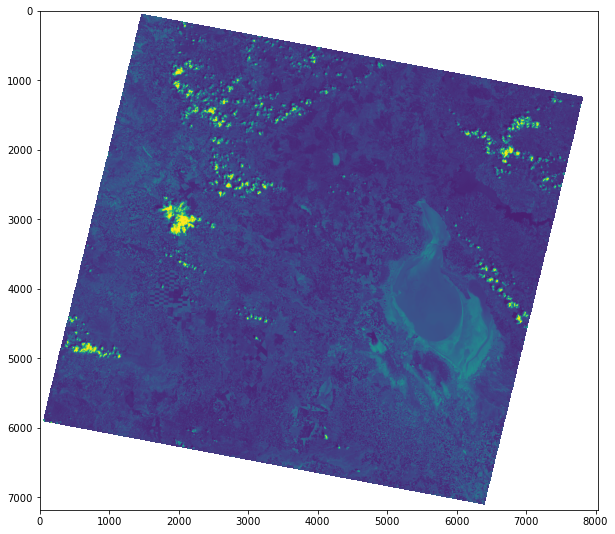

In [31]:
# Display band numbers 
plt.rcParams['figure.figsize'] = [10, 20]


mydata = {'band_2': band_2,
          'band_3': band_3,
          'band_4': band_4,
          'band_5': band_5,
          'band_6': band_6,}

default = 'band_2'
plt.imshow(mydata[default])
w = widgets.Dropdown(
    options=mydata.keys(),
    value = default,
    description='List',
)

display(w)
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        # sns.boxplot(data = mydata[change['new']])
        plt.imshow(mydata[change['new']])

w.observe(on_change)

Dropdown(description='List', options=('ndvi', 'ndwi', 'ndbi', 'mndwi'), value='ndvi')

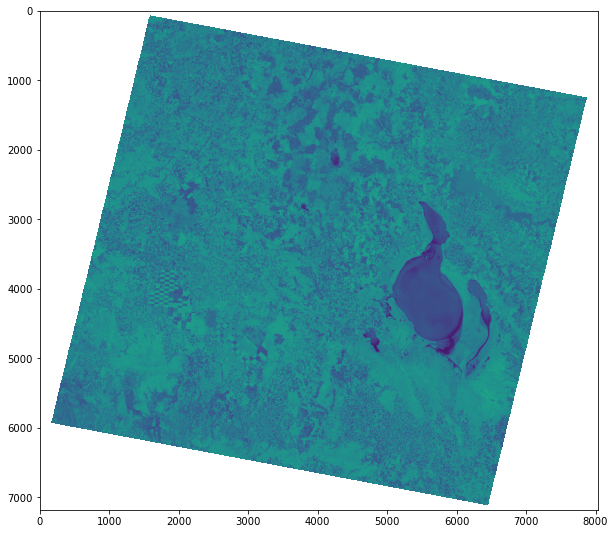

In [34]:
# Display indeces  

ndvi = lake.calculate_ndvi(band_5, band_4)
ndwi = lake.calculate_ndwi(band_5, band_6)
ndbi = lake.calculate_ndbi(band_6, band_5)
mndwi = lake.calculate_mndwi(band_3, band_6)

lake.export_index_to_raster(ndvi, "ndvi")
lake.export_index_to_raster(ndbi, "ndbi")
lake.export_index_to_raster(ndwi, "ndwi")
lake.export_index_to_raster(mndwi, "mndwi")


plt.rcParams['figure.figsize'] = [10, 20]


mydata = {'ndvi': ndvi,
          'ndwi': ndwi,
          'ndbi': ndbi,
          'mndwi': mndwi,}

default = 'ndvi'
plt.imshow(mydata[default])
w = widgets.Dropdown(
    options=mydata.keys(),
    value = default,
    description='List',
)

display(w)
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        # sns.boxplot(data = mydata[change['new']])
        plt.imshow(mydata[change['new']])

w.observe(on_change)


In [28]:
from ipywidgets import HBox, Label
style = {'description_width': 'initial'}

lake_raster_name = "lake"

a = widgets.IntSlider(description='NDVI', style=style, min=-1000, max=1000, step=1, value = 0 )
b = widgets.IntSlider(description='NDWI', style=style, min=-1000, max=1000, step=1, value = 400)
c = widgets.IntSlider(description='MNDWI', style=style, min=-1000, max=1000, step=1, value= 400)
ui = widgets.HBox([ a, b, c])
def f(a, b, c):
    print(a)
    # value = (ndvi < int(a)) & (ndwi > int(b)) & (mndwi> int(c))
    value = (ndvi < int(a)) & (mndwi> int(c))
    lake.export_index_to_raster(value, lake_raster_name)
    plt.imshow(value)
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [14]:
# Convert raster lake file to polygon 
polygon_name = "lake_in_polygon"
lake.convert_to_polygon("lake", polygon_name)


In [17]:
# Convert Shapefile to geojson to dipslay on the map 
geojson_name = "lake_in_geojson"
lake.convert(polygon_name, geojson_name)
lake.convert("KCB_ramsar", "KCB_ramsar")

/usr/lib/python3/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/lib/python3/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/lib/python3/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:/

In [19]:
from ipyleaflet import Map, basemaps,GeoJSON, SplitMapControl,LayersControl
import ipywidgets as ipyw
import geopandas as gpd
import random

import json 
json_name = os.path.join(lake.process_path, lake.output_folder, "lake_in_geojson.json" )
json_name_KCB_ramsar = os.path.join(lake.process_path, lake.output_folder, "KCB_ramsar.json" )


def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }


with open(json_name, 'r') as f:
    data = json.load(f)

with open(json_name_KCB_ramsar, 'r') as f:
    data_kcb = json.load(f)

    
    

# Center map to turkey 
center = [38.128, 38.588]

# Arrange zoom level 
zoom = 6

# Diplay map
m = Map(basemap=basemaps.OpenStreetMap.Mapnik,center=center, zoom=zoom)
geo_json = GeoJSON(name="lake", data=data,
                  style={'opacity': 0.8, 'fillOpacity': 0.1, 'weight': 1}
                  )
geo_json_data_kcb = GeoJSON(name="ramsar",data=data_kcb,
                            style={'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1},
                            hover_style={'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5},
                            style_callback=random_color)

control = SplitMapControl(left_layer=geo_json, right_layer=geo_json_data_kcb)
l_control = LayersControl(position='topright')

m.add_layer(geo_json)
m.add_layer(geo_json_data_kcb)
# m.add_control(control)
m.add_control(l_control)

m

Map(center=[38.128, 38.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…